# Step 01

### Importing pyspark and required libraries

In [42]:
# To specify the environment (using mongo spark connector)
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'

# Create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
from pyspark.sql import functions as F  # Functions

# For step 6 (Converting a column data type into date datatype)
from datetime import datetime
from pyspark.sql.functions import col, udf, concat, lit
from pyspark.sql.types import DateType

# To extract a part of the date
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import dayofweek

# For step 7 (To perform aggregation)
from pyspark.sql import functions as F

# For step 8 (To plot graphs)
import matplotlib.pyplot as plt 
%matplotlib inline

# Importing numpy
import numpy as np

### Initializing spark

In [43]:
# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]", appName="Analysing CSV Data")
    
my_spark = SparkSession(sparkContext=sc)\
    .builder \
    .appName("Analyse_CSV_Data") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/assign1_db.csv_data") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/assign1_db.csv_data") \
    .getOrCreate()

print(sc)
print(my_spark)

<SparkContext master=local[*] appName=pyspark-shell>


### Saving file location into a variable

In [44]:
# For part B (CSV file)
# Change the file path accordingly to run
csvFile = '/srv/home/sver0016/FIT5202/Assignment 1/Datasets-20190815/Datasets/Crime_Statistics_SA_2010_present.csv'

# Step 02

### Creating dataframe

In [45]:
# Creating a dataframe from the csv file
csvFileDF = my_spark.read.csv(csvFile, inferSchema=True, header=True)

### Displaying total number of records

In [46]:
# Number of records without filtering for null values
print("Number of records in CSV file before filtering null values : ",csvFileDF.count())

Number of records in CSV file before filtering null values :  727408


In [47]:
# Checking for Null values in each column 

print('Nulls in Reported date column : ', csvFileDF.filter(F.col('Reported Date').isNull()).count())
print('Nulls in Suburb - Incident column : ', csvFileDF.filter(F.col('Suburb - Incident').isNull()).count())
print('Nulls in Postcode - Incident column : ', csvFileDF.filter(F.col('Postcode - Incident').isNull()).count())
print('Nulls in Offence Level 1 Description column : ', csvFileDF.filter(F.col('Offence Level 1 Description').isNull()).count())
print('Nulls in Offence Level 2 Description column : ', csvFileDF.filter(F.col('Offence Level 2 Description').isNull()).count())
print('Nulls in Offence Level 3 Description column : ', csvFileDF.filter(F.col('Offence Level 3 Description').isNull()).count())
print('Nulls in Offence Count column : ', csvFileDF.filter(F.col('Offence Count').isNull()).count())

Nulls in Reported date column :  1
Nulls in Suburb - Incident column :  161
Nulls in Postcode - Incident column :  482
Nulls in Offence Level 1 Description column :  1
Nulls in Offence Level 2 Description column :  1
Nulls in Offence Level 3 Description column :  1
Nulls in Offence Count column :  1


**Explanation :**

The result for above code implies that there is atleast a null value in each column of the dataframe. There is a possibility of null row that might create problem in our analysis at later stages. Since that row has no data in it, we can remove it directly.

In [48]:
# Number of records without filtering for null values
csvFileDF = csvFileDF.na.drop(how='all')
print("Number of records in CSV file after filtering null values : ",csvFileDF.count())

Number of records in CSV file after filtering null values :  727407


In [49]:
print('Nulls in Reported date column : ', csvFileDF.filter(F.col('Reported Date').isNull()).count())
print('Nulls in Suburb - Incident column : ', csvFileDF.filter(F.col('Suburb - Incident').isNull()).count())
print('Nulls in Postcode - Incident column : ', csvFileDF.filter(F.col('Postcode - Incident').isNull()).count())
print('Nulls in Offence Level 1 Description column : ', csvFileDF.filter(F.col('Offence Level 1 Description').isNull()).count())
print('Nulls in Offence Level 2 Description column : ', csvFileDF.filter(F.col('Offence Level 2 Description').isNull()).count())
print('Nulls in Offence Level 3 Description column : ', csvFileDF.filter(F.col('Offence Level 3 Description').isNull()).count())
print('Nulls in Offence Count column : ', csvFileDF.filter(F.col('Offence Count').isNull()).count())

Nulls in Reported date column :  0
Nulls in Suburb - Incident column :  160
Nulls in Postcode - Incident column :  481
Nulls in Offence Level 1 Description column :  0
Nulls in Offence Level 2 Description column :  0
Nulls in Offence Level 3 Description column :  0
Nulls in Offence Count column :  0


**Explanation :**

The previous step handled nulls which occurred throughout the row but as we can see in the results above, there are other nulls which occur randomly in a single field under a single column.

In [50]:
csvFileDF = csvFileDF.fillna({"Suburb - Incident":"Empty", "Postcode - Incident":'0000'})

In [51]:
csvFileDF.filter(F.col('Suburb - Incident') == 'Empty').count()

160

In [52]:
csvFileDF.filter(F.col('Postcode - Incident') == '0000').count()

481

**Explanation :**

Over here, I have replaced the null values in _'SUburb - Incident'_ column and _'Postcode - Incident'_ column with _'Empty'_ and _'0000'_ respectively. If these values pop up in our analysis later, I can filter these values directly. I did so that null values don't affect our analysis in the later stages.

In [53]:
print('Nulls in Reported date column : ', csvFileDF.filter(F.col('Reported Date').isNull()).count())
print('Nulls in Suburb - Incident column : ', csvFileDF.filter(F.col('Suburb - Incident').isNull()).count())
print('Nulls in Postcode - Incident column : ', csvFileDF.filter(F.col('Postcode - Incident').isNull()).count())
print('Nulls in Offence Level 1 Description column : ', csvFileDF.filter(F.col('Offence Level 1 Description').isNull()).count())
print('Nulls in Offence Level 2 Description column : ', csvFileDF.filter(F.col('Offence Level 2 Description').isNull()).count())
print('Nulls in Offence Level 3 Description column : ', csvFileDF.filter(F.col('Offence Level 3 Description').isNull()).count())
print('Nulls in Offence Count column : ', csvFileDF.filter(F.col('Offence Count').isNull()).count())

Nulls in Reported date column :  0
Nulls in Suburb - Incident column :  0
Nulls in Postcode - Incident column :  0
Nulls in Offence Level 1 Description column :  0
Nulls in Offence Level 2 Description column :  0
Nulls in Offence Level 3 Description column :  0
Nulls in Offence Count column :  0


**Explanation :**

We can see in the above results that there are no null values in our dataframe now. As the next step, we can write it to the database.

# Step 03

### Writing to Database

In [54]:
csvFileDF.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

# Step 04

### Reading from Database

In [55]:
df = my_spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
df.show(5)

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            2|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|               5000|    1/07/2010|         ADELAIDE|[5d71f283bc6fa442...|
|            2|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|               5000|    1/07/2010|         ADELAIDE|[5d71f283bc6fa442...|
|            1|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|               5000|    1/07/2010|  

### Displaying schema of the dataframe

In [56]:
df.printSchema() # this prints the schema created in Spark 

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



# Step 05

### Calculating the statistics of numeric and string columns

In [57]:
df.describe(['Offence Count','Reported Date']).show()

+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            727407|       727407|
|   mean|1.1715174585892079|         null|
| stddev|0.5787050930378086|         null|
|    min|                 1|    1/01/2011|
|    max|                28|    9/12/2018|
+-------+------------------+-------------+



**Explanation**: 

We can calculate the statistical parameters such as count, mean, standard deviation, minimum and maximum of a column which has numeric values. We can use _'describe()'_ on a DataFrame for such type of columns. Here, Offence count is in the form of an integer and that is why statistical parameters can be calculated whereas Reported Date is in the form of a string and that is why we can't calculate the statistical parameters mentioned earlier. Hence, the stats for the Reported Date column are incorrect.

# Step 06

### Changing the data type of a column

In [58]:
if df.select(['Reported Date']).dtypes[0][1] != 'date':
    # Setting an user define function: This function converts the string cell into a date:
    dateUdf =  udf (lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())
    df = df.withColumn('Reported Date', dateUdf(col('Reported Date')))

In [59]:
df.show(5)

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            2|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|               5000|   2010-07-01|         ADELAIDE|[5d71f283bc6fa442...|
|            2|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|               5000|   2010-07-01|         ADELAIDE|[5d71f283bc6fa442...|
|            1|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|               5000|   2010-07-01|  

In [60]:
df.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



**Explanation :**

We can see that the data type for _'Reported Date'_ column has changed from _'string'_ to _'date'_. Also, the format for the _'Reported Date'_ column has changed. For example: Earlier, _'Reported Date'_ had the date as '18/06/2014' and later, after we run the udf, _'Reported Date'_ has the date as '2014-06-18'.

# Step 07

### Displaying total number of level 2 offenses and the list of level 2 offenses

In [61]:
level2OffenseCount = df.select('Offence Level 2 Description').distinct().count()
print('Number of level 2 offenses : ', level2OffenseCount)

Number of level 2 offenses :  9


In [62]:
df.select('Offence Level 2 Description').distinct().show(20, False)

+------------------------------------+
|Offence Level 2 Description         |
+------------------------------------+
|ROBBERY AND RELATED OFFENCES        |
|PROPERTY DAMAGE AND ENVIRONMENTAL   |
|SEXUAL ASSAULT AND RELATED OFFENCES |
|HOMICIDE AND RELATED OFFENCES       |
|ACTS INTENDED TO CAUSE INJURY       |
|SERIOUS CRIMINAL TRESPASS           |
|OTHER OFFENCES AGAINST THE PERSON   |
|FRAUD DECEPTION AND RELATED OFFENCES|
|THEFT AND RELATED OFFENCES          |
+------------------------------------+



### Displaying number of offenses against a person

In [63]:
print('Number of offences against the person under Offence Level 1 Description  : ', 
       df.where(col("Offence Level 1 Description").isin({"OFFENCES AGAINST THE PERSON"})).count())

Number of offences against the person under Offence Level 1 Description  :  156062


**Explanation :**

Here, I've calculated the total count of the 'OFFENCES AGAINST THE PERSON' under the column 'Offence Level 1 Description'. This provides the categorical information.

In [64]:
print('Number of offence count for the offences against the person : ', 
      df.where(col("Offence Level 1 Description").isin({"OFFENCES AGAINST THE PERSON"})).agg(F.sum("Offence Count")).collect()[0][0])

Number of offence count for the offences against the person :  175644


**Explanation :**

Here, I've calculated the total number of offence count for the 'OFFENCES AGAINST THE PERSON' category under the column 'Offence Level 1 Description'. This displays the total offence counts for offences against the person.

### Displaying number of serious criminal trespass with more than 1 offence count

In [65]:
print('Number of serious criminal trespass with more than 1 offence count : ',
      df.filter((col("Offence Level 2 Description").isin({"SERIOUS CRIMINAL TRESPASS"})) & (col('Offence Count') > 1)).count())

Number of serious criminal trespass with more than 1 offence count :  8579


### Displaying percentage of crimes that are offences against the property

In [66]:
totalOffenceCount = df.select("Offence Level 1 Description").count()
propertyOffenseCount = df.filter(col("Offence Level 1 Description").isin({"OFFENCES AGAINST PROPERTY"})).count()
print('Percentage of crimes that are offences against the property (Categorical information) : ', round((propertyOffenseCount/totalOffenceCount)*100,2))

Percentage of crimes that are offences against the property (Categorical information) :  78.55


**Explanation :**

The above code displays the categorical information - total count of the _'OFFENCES AGAINST PROPERTY'_ over total count of _'Offence Level 1 Description'_ column multiplied by 100. This gives us the percentage value that is rounded off to two decimal points.

In [67]:
totalOffenceCount = df.agg(F.sum("Offence Count")).collect()[0][0]
propertyOffenseCount = df.filter(col("Offence Level 1 Description").isin({"OFFENCES AGAINST PROPERTY"})).agg(F.sum("Offence Count")).collect()[0][0]
print('Percentage of crimes that are offences against the property (Numerical information) : ', round((propertyOffenseCount/totalOffenceCount)*100,2))

Percentage of crimes that are offences against the property (Numerical information) :  79.39


**Explanation :**

The above code displays the numerical information - total offence count of the _'OFFENCES AGAINST PROPERTY'_ over total offence count under the _'Offence Count'_ column multiplied by 100. This gives us the percentage value that is rounded off to two decimal points.

# Step 08

### Finding the number of crimes per year

In [68]:
df.groupBy(year(col("Reported Date"))).sum().orderBy(year(col("Reported Date"))) \
  .select(col('year(Reported Date)').alias("Year"), col('sum(Offence Count)').alias("Number Of Crimes")) \
  .show()

+----+----------------+
|Year|Number Of Crimes|
+----+----------------+
|2010|           61402|
|2011|          122204|
|2012|          112962|
|2013|          106782|
|2014|          101750|
|2015|          105656|
|2016|          107593|
|2017|           50159|
|2018|           55758|
|2019|           27904|
+----+----------------+



In [69]:
# Crimes per year

yearDisplay = df.groupBy(year(col("Reported Date"))).sum().orderBy(year(col("Reported Date"))) \
                .select(col('year(Reported Date)')).collect() # for extracting year

crimePerYearCount = df.groupBy(year(col("Reported Date"))).sum().orderBy(year(col("Reported Date"))) \
             .select(col('sum(Offence Count)')).collect() # for extracting total offence count

# Initializing lists to store year and total offence count
yearList = []
crimePerYearCountList = []

# Storing each value from dataframe above into the lists
for i in range(len(yearDisplay)):
    yearList.append(yearDisplay[i][0])
    crimePerYearCountList.append(crimePerYearCount[i][0])

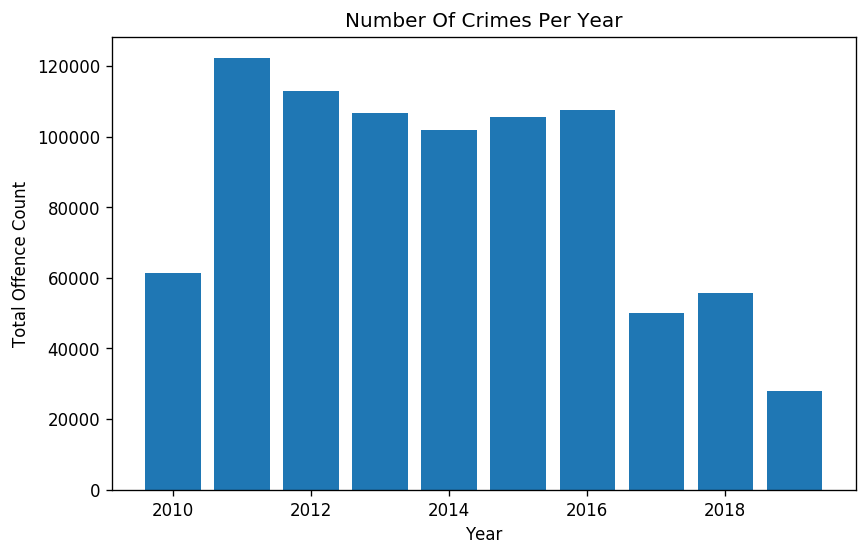

In [70]:
# Setting figure size
plt.figure(figsize=[8,5], dpi=120)

# Plotting the graph
plt.bar(yearList,crimePerYearCountList)
plt.xlabel('Year')
plt.ylabel('Total Offence Count')
plt.title('Number Of Crimes Per Year')
plt.show()

**Explanation :**

The above graph is a bar chart which depicts the number of crimes committed per year ranging from years 2010 to 2019. In the beginning, the total offence count was just over 60,000 and by the end of the period, it dropped down to close to 30,000. We can see in the graph that there was a sharp rise of about 6000 crimes from the year 2010 to 2011 and there on, gradual decrease until year 2016. The crime rate drastically reduced by 5000 crimes in the year 2017. It can also be observed from the graph that most number of crimes were committed in the year 2011 whereas the least number of crimes were committed in the year 2019 (This may be because the year 2019 hasn't completed yet, the actual/true crime count will reflect for the previous years and not the current year). 

### Finding number of crimes per month

In [71]:
df.groupBy(month(col("Reported Date"))).sum().orderBy(month(col("Reported Date"))) \
  .select(col('month(Reported Date)').alias("Month"), col('sum(Offence Count)').alias("Number Of Crimes")) \
  .show()

+-----+----------------+
|Month|Number Of Crimes|
+-----+----------------+
|    1|           77516|
|    2|           70429|
|    3|           74931|
|    4|           60037|
|    5|           64246|
|    6|           60687|
|    7|           70954|
|    8|           72839|
|    9|           72595|
|   10|           77153|
|   11|           75191|
|   12|           75592|
+-----+----------------+



In [72]:
# Crimes per month

monthDisplay = df.groupBy(month(col("Reported Date"))).sum().orderBy(month(col("Reported Date"))) \
                .select(col('month(Reported Date)')).collect() # for extracting month

crimePerMonthCount = df.groupBy(month(col("Reported Date"))).sum().orderBy(month(col("Reported Date"))) \
             .select(col('sum(Offence Count)')).collect() # for extracting total offence count

# Initializing lists to store month and total offence count
monthList = []
crimePerMonthCountList = []

# Storing each value from dataframe above into the lists
for i in range(len(monthDisplay)):
    monthList.append(monthDisplay[i][0])
    crimePerMonthCountList.append(crimePerMonthCount[i][0])    

# Setting month name based on month number
for j in range(len(monthDisplay)):
    if monthList[j] == 1:
        monthList[j] = 'Jan'
    elif monthList[j] == 2:
        monthList[j] = 'Feb'
    elif monthList[j] == 3:
        monthList[j] = 'Mar'
    elif monthList[j] == 4:
        monthList[j] = 'Apr'
    elif monthList[j] == 5:
        monthList[j] = 'May'
    elif monthList[j] == 6:
        monthList[j] = 'Jun'
    elif monthList[j] == 7:
        monthList[j] = 'Jul'
    elif monthList[j] == 8:
        monthList[j] = 'Aug'
    elif monthList[j] == 9:
        monthList[j] = 'Sep'
    elif monthList[j] == 10:
        monthList[j] = 'Oct'
    elif monthList[j] == 11:
        monthList[j] = 'Nov'
    elif monthList[j] == 12:
        monthList[j] = 'Dec'

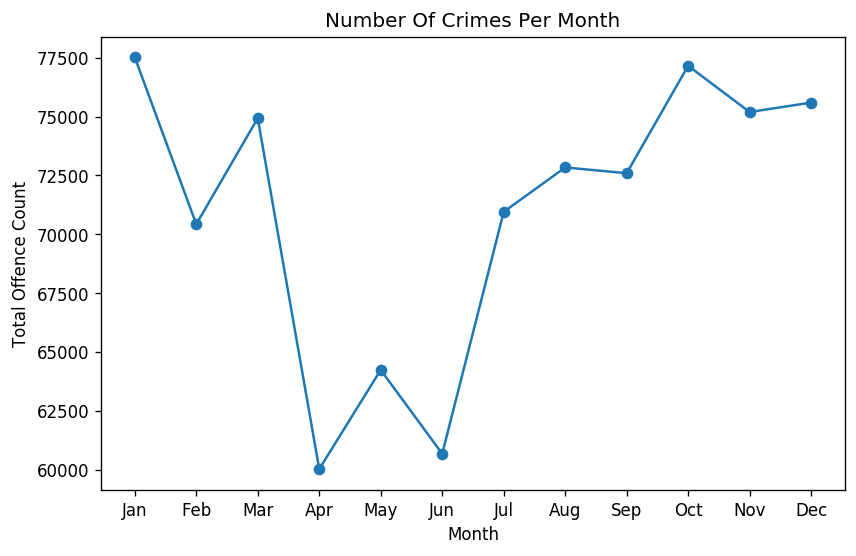

In [73]:
# Setting figure size
plt.figure(figsize=[8,5], dpi=120)

# Plotting the graph
plt.plot(monthList,crimePerMonthCountList, 'o-')
plt.xlabel('Month')
plt.ylabel('Total Offence Count')
plt.title('Number Of Crimes Per Month')
plt.show()

**Explanation :**

The above graph is a line chart depicts the number of crimes committed per month ranging from months Jan to Dec. In the beginning, the total offence count was just over 77,500 and by the end of the period, it dropped down to close to 75,000. We can see in the graph that there was a fall in the crime rate from Jan to Feb by around 7,500 crimes and then there was an increase in the crimes from Feb to Mar. There after, we see a steep decrease in the crime rate by about 15,000 crimes from Mar to Apr and dramatic increment of close to 10,000 crimes in the crime rate from Jun to Jul. From Jul to Sep, we see gradual increase in the crime rate while the crime rate touches it's peak in the month of Oct. Later, by Dec, it goes down to 76,000.It can also be observed from the graph that most number of crimes were committed in the month Oct whereas the least number of crimes were committed in the month Apr.

### Finding number of crimes per suburb

As we've filled the null values earlier for _'Suburb - Incident'_ and _'Postcode - Incident'_ , let's check if nulls have any effect on our requirement i.e. finding number of crimes per suburb (top 20).

In [74]:
df.groupBy((concat((col('Suburb - Incident')), lit('-'),(col('Postcode - Incident'))).alias('Suburb-Postcode'))) \
  .sum("Offence Count") \
  .orderBy(col("sum(Offence Count)"), ascending=False) \
  .select(col('Suburb-Postcode'), col('sum(Offence Count)').alias("Number Of Crimes")) \
  .show(20, False)

+---------------------------+----------------+
|Suburb-Postcode            |Number Of Crimes|
+---------------------------+----------------+
|ADELAIDE-5000              |46701           |
|PORT AUGUSTA-5700          |13711           |
|MOUNT GAMBIER-5290         |13709           |
|MURRAY BRIDGE-5253         |12919           |
|MORPHETT VALE-5162         |12569           |
|SALISBURY-5108             |10806           |
|PORT LINCOLN-5606          |10779           |
|ELIZABETH-5112             |10731           |
|NOT DISCLOSED-NOT DISCLOSED|9375            |
|DAVOREN PARK-5113          |8082            |
|PARAFIELD GARDENS-5107     |8040            |
|OAKLANDS PARK-5046         |7792            |
|PARALOWIE-5108             |7261            |
|PROSPECT-5082              |7234            |
|PORT PIRIE-5540            |7155            |
|MODBURY-5092               |7041            |
|SMITHFIELD-5114            |7000            |
|SALISBURY NORTH-5108       |6538            |
|WHYALLA STUA

**Explanation :**

Although the nulls have no effect on the required data, we can see that there is an entry which has _'NOT DISCLOSED-NOT DISCLOSED'_ in the Suburb-Postcode column which doesn't gives actual suburb-incident information. So, I've displayed both cases - one, considering the suburbs which aren't disclosed and second, removing the 'NOT DISCLOSED' suburbs(steps shown below). We can see that _'ADELAIDE-5000'_ is the place where most crime occurs.

In [75]:
# Crimes per suburb

suburbDisplay = df.groupBy((concat((col('Suburb - Incident')), lit('-'),(col('Postcode - Incident'))).alias('Suburb-Postcode'))) \
                  .sum("Offence Count") \
                  .orderBy(col("sum(Offence Count)"), ascending=False) \
                  .select(col('Suburb-Postcode')) \
                  .collect() # for extracting suburb

crimePerSuburbCount = df.groupBy((concat((col('Suburb - Incident')), lit('-'),(col('Postcode - Incident'))).alias('Suburb-Postcode'))) \
             .sum("Offence Count") \
             .orderBy(col("sum(Offence Count)"), ascending=False) \
             .select(col('sum(Offence Count)')) \
             .collect() # for extracting total offence count

# Initializing lists to store year and total offence count
suburbList = []
crimePerSuburbList = []

# Storing each value from dataframe above into the lists
for i in range(0, 20):
    suburbList.append(suburbDisplay[i][0])
    crimePerSuburbList.append(crimePerSuburbCount[i][0])

In [76]:
# Setting figure size
plt.figure(figsize=[50,20], dpi=300)

# Setting fontsize for each item
ax = plt.subplot(111, xlabel='Total Offense Count', ylabel='Suburb-Postcode', title='Number Of Crimes Per Suburb-Postcode')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)

# Plotting the graph
plt.barh(suburbList, crimePerSuburbList)
plt.gca().invert_yaxis()
plt.show()

**Explanation :**

The above graph displays total number of crimes per Suburb-Postcode for 20 suburbs. We see that _'ADELAIDE-5000'_ is the suburb where the most number of crimes take place with crime count being over 45,000 whereas _'MAWSON LAKES-5095'_ is the suburb where the least number of crimes take place with crime count being around 6000 from the top 20 list we picked.

There is a suburb-postcode entry whose details aren't disclosed. It is depicted as _'NOT DISCLOSED-NOT DISCLOSED'_ and has the crime count of about 10,000.

As mentioned earlier, below steps show the information excluding _'NOT DISCLOSED-NOT DISCLOSED'_ Suburb-Postcode.

In [77]:
df.groupBy((concat((col('Suburb - Incident')), lit('-'),(col('Postcode - Incident'))).alias('Suburb-Postcode'))) \
  .sum("Offence Count") \
  .orderBy(col("sum(Offence Count)"), ascending=False) \
  .filter(col('Suburb-Postcode').isin({"NOT DISCLOSED-NOT DISCLOSED"}) == False) \
  .select(col('Suburb-Postcode'), col('sum(Offence Count)').alias("Number Of Crimes")) \
  .show(20, False)

+----------------------+----------------+
|Suburb-Postcode       |Number Of Crimes|
+----------------------+----------------+
|ADELAIDE-5000         |46701           |
|PORT AUGUSTA-5700     |13711           |
|MOUNT GAMBIER-5290    |13709           |
|MURRAY BRIDGE-5253    |12919           |
|MORPHETT VALE-5162    |12569           |
|SALISBURY-5108        |10806           |
|PORT LINCOLN-5606     |10779           |
|ELIZABETH-5112        |10731           |
|DAVOREN PARK-5113     |8082            |
|PARAFIELD GARDENS-5107|8040            |
|OAKLANDS PARK-5046    |7792            |
|PARALOWIE-5108        |7261            |
|PROSPECT-5082         |7234            |
|PORT PIRIE-5540       |7155            |
|MODBURY-5092          |7041            |
|SMITHFIELD-5114       |7000            |
|SALISBURY NORTH-5108  |6538            |
|WHYALLA STUART-5608   |6297            |
|MAWSON LAKES-5095     |6103            |
|WHYALLA NORRIE-5608   |5837            |
+----------------------+----------

In [78]:
# Crimes per suburb

suburbDisplay = df.groupBy((concat((col('Suburb - Incident')), lit('-'),(col('Postcode - Incident'))).alias('Suburb-Postcode'))) \
                  .sum("Offence Count") \
                  .orderBy(col("sum(Offence Count)"), ascending=False) \
                  .filter(col('Suburb-Postcode').isin({"NOT DISCLOSED-NOT DISCLOSED"}) == False) \
                  .select(col('Suburb-Postcode')) \
                  .collect() # for extracting suburb

crimePerSuburbCount = df.groupBy((concat((col('Suburb - Incident')), lit('-'),(col('Postcode - Incident'))).alias('Suburb-Postcode'))) \
             .sum("Offence Count") \
             .orderBy(col("sum(Offence Count)"), ascending=False) \
             .filter(col('Suburb-Postcode').isin({"NOT DISCLOSED-NOT DISCLOSED"}) == False) \
             .select(col('sum(Offence Count)')) \
             .collect() # for extracting total offence count

# Initializing lists to store year and total offence count
suburbList = []
crimePerSuburbList = []

# Storing each value from dataframe above into the lists
for i in range(0, 20):
    suburbList.append(suburbDisplay[i][0])
    crimePerSuburbList.append(crimePerSuburbCount[i][0])

In [79]:
# Setting figure size
plt.figure(figsize=[50,20], dpi=300)

# Setting fontsize for each item
ax = plt.subplot(111, xlabel='Total Offense Count', ylabel='Suburb-Postcode', title='Number Of Crimes Per Suburb-Postcode')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(50)

# Plotting the graph
plt.barh(suburbList, crimePerSuburbList)
plt.gca().invert_yaxis()
plt.show()

**Explanation :**

It can be seen in the graph as well as code output above that instead of _'NOT DISCLOSED-NOT DISCLOSED'_ , we get _'WHYALLA NORRIE-5608'_ which has crime count of little less than 6000, behind of _'MAWSON LAKES-5095'_ with crime count just over 6000.

In [80]:
# Number of serious criminal trespass per day of the week per month
df.groupBy(month(col("Reported Date")), dayofweek(col("Reported Date")), col('Offence Level 2 Description')).sum('Offence Count') \
  .orderBy(month(col("Reported Date")), dayofweek(col("Reported Date"))) \
  .where(col('Offence Level 2 Description').isin({"SERIOUS CRIMINAL TRESPASS"})) \
  .select(col('month(Reported Date)').alias("Month"), col('dayofweek(Reported Date)').alias("Day Of Week"), col('sum(Offence Count)').alias("Number Of Crimes")) \
  .show()

+-----+-----------+----------------+
|Month|Day Of Week|Number Of Crimes|
+-----+-----------+----------------+
|    1|          1|            1309|
|    1|          2|            1722|
|    1|          3|            1681|
|    1|          4|            1513|
|    1|          5|            1412|
|    1|          6|            1524|
|    1|          7|            1246|
|    2|          1|            1143|
|    2|          2|            1661|
|    2|          3|            1376|
|    2|          4|            1325|
|    2|          5|            1260|
|    2|          6|            1376|
|    2|          7|            1118|
|    3|          1|            1310|
|    3|          2|            1609|
|    3|          3|            1486|
|    3|          4|            1338|
|    3|          5|            1442|
|    3|          6|            1436|
+-----+-----------+----------------+
only showing top 20 rows



**Explanation :**

Here, month starting from 1 to 12 implies the month number in a year. January corresponds to 1, February corresponds to 2 and so on. 

Similarly, day of the week starting from 1 to 7 implies the day number. Sunday corresponds to 1, Monday corresponds to 2 and so on.

In [81]:
listing = df.groupBy(month(col("Reported Date")), dayofweek(col("Reported Date")), col('Offence Level 2 Description')).sum('Offence Count') \
  .orderBy(month(col("Reported Date")), dayofweek(col("Reported Date"))) \
  .where(col('Offence Level 2 Description').isin({"SERIOUS CRIMINAL TRESPASS"})) \
  .select(col('month(Reported Date)').alias("Month"), col('dayofweek(Reported Date)').alias("Day Of Week"), col('sum(Offence Count)').alias("Number Of Crimes")) \
  .collect()
    
    
# Function to convert month number into month name of the year

def monthFunc(month):
    if month == 1:
        return 'Jan'
    elif month == 2:
        return 'Feb'
    elif month == 3:
        return 'Mar'
    elif month == 4:
        return 'Apr'
    elif month == 5:
        return 'May'
    elif month == 6:
        return 'Jun'
    elif month == 7:
        return 'Jul' 
    elif month == 8:
        return 'Aug'
    elif month == 9:
        return 'Sep'
    elif month == 10:
        return 'Oct'
    elif month == 11:
        return 'Nov'
    elif month == 12:
        return 'Dec'

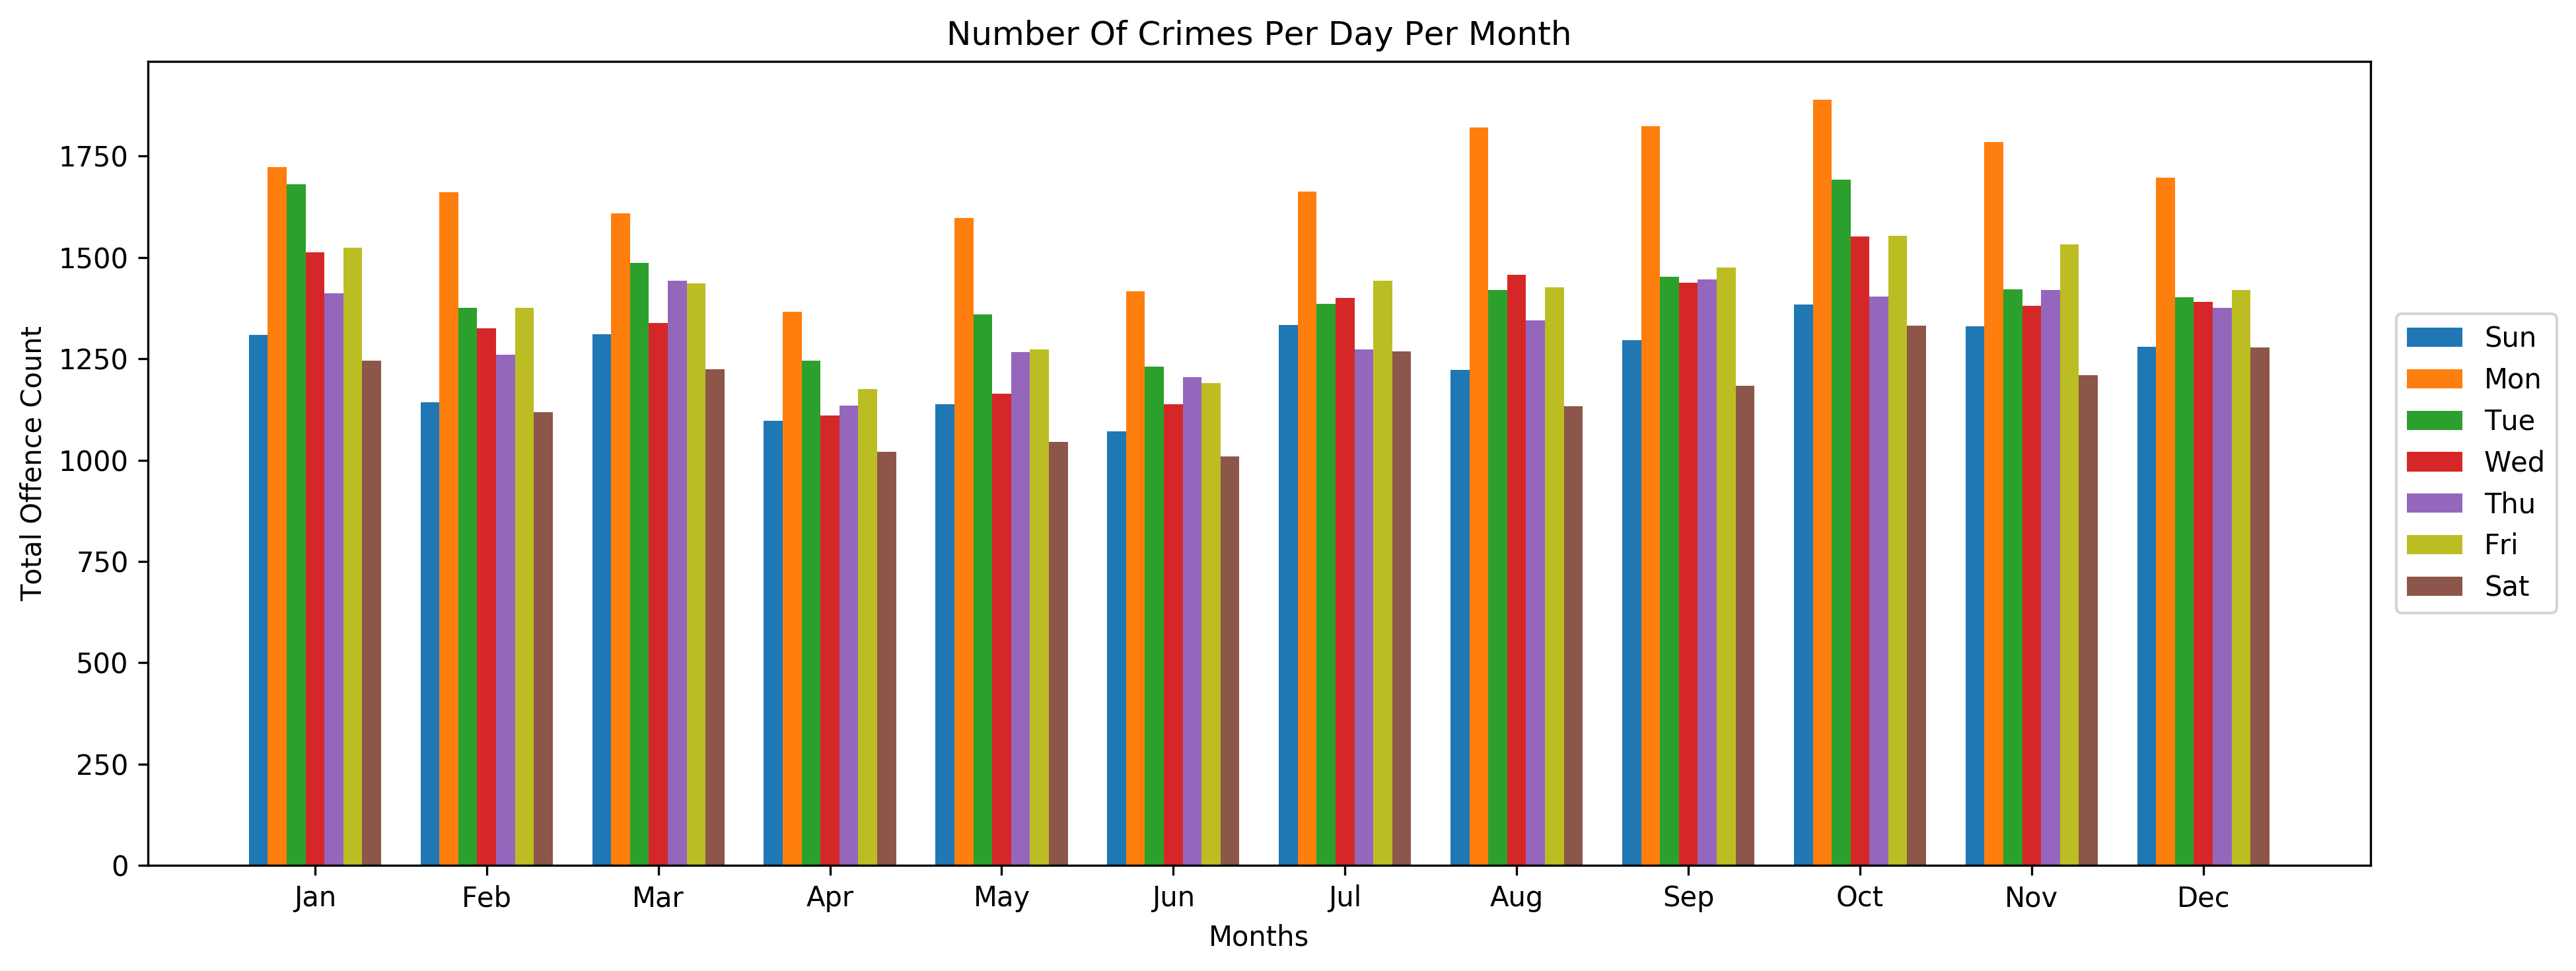

In [82]:
# Grouping days in the week per month

sun = [monthFunc(row['Month']) for row in listing if row['Day Of Week']==1]
mon = [monthFunc(row['Month']) for row in listing if row['Day Of Week']==2]
tue = [monthFunc(row['Month']) for row in listing if row['Day Of Week']==3]
wed = [monthFunc(row['Month']) for row in listing if row['Day Of Week']==4]
thu = [monthFunc(row['Month']) for row in listing if row['Day Of Week']==5]
fri = [monthFunc(row['Month']) for row in listing if row['Day Of Week']==6]
sat = [monthFunc(row['Month']) for row in listing if row['Day Of Week']==7]

# Grouping offence count per day in the week per month

sunCount = [row['Number Of Crimes'] for row in listing if row['Day Of Week']==1]
monCount = [row['Number Of Crimes'] for row in listing if row['Day Of Week']==2]
tueCount = [row['Number Of Crimes'] for row in listing if row['Day Of Week']==3]
wedCount = [row['Number Of Crimes'] for row in listing if row['Day Of Week']==4]
thuCount = [row['Number Of Crimes'] for row in listing if row['Day Of Week']==5]
friCount = [row['Number Of Crimes'] for row in listing if row['Day Of Week']==6]
satCount = [row['Number Of Crimes'] for row in listing if row['Day Of Week']==7]

# Setting figure size
plt.figure(figsize=[13, 5], dpi=300)
    
width = 0.11
indices = np.arange(12)
months = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.bar(indices-3*width, sunCount, width, color='C0', label='Sun', align='center')
plt.bar(indices-2*width, monCount, width, color='C1', label='Mon', align='center')
plt.bar(indices-1*width, tueCount, width, color='C2', label='Tue', align='center')
plt.bar(indices, wedCount, width, color='C3', label='Wed', align='center')
plt.bar(indices+1*width, thuCount, width, color='C4', label='Thu', align='center')
plt.bar(indices+2*width, friCount, width, color='C8', label='Fri', align='center')
plt.bar(indices+3*width, satCount, width, color='C5', label='Sat', align='center')

plt.legend(loc = 7, bbox_to_anchor=(1.09,0.5))
plt.title("Number Of Crimes Per Day Per Month")
plt.xlabel("Months")
plt.ylabel("Total Offence Count")
plt.xticks(indices, months)

plt.tight_layout()
plt.show()

**Explanation :**

The above graph represents the number of crimes per day of the week per month. The x-axis shows the months while y-axis shows the total offence count and different bars show different days (color mapping provided in legend).

Overall, we can observe the trend that most number of crimes were committed on monday whereas least number of crimes were committed on saturday for each and every month. It appears that wednesday is the 'middle man' as the number of crimes committed on that day isn't too low or too high.

The number of crimes on Monday for all the months is high (ranges from 1,300 to 1,800) compared to the number of crimes on Tuesday, Wednesday, Thursday and Friday (ranges from 1,200 to 1,400). Highest crime count (over 1,800) was observed on Monday October whereas the least crime count (around 1,000) was observed on Saturday for the month June.

It can be deduced from the graph that October has the highest crime count whereas April has the least crime count. Also, we can see that most crimes were committed in the later half of the year compared to the first half of the year.

# References

- Monash tutorials and lecture demo files

- https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html

- https://www.edureka.co/blog/pyspark-dataframe-tutorial/

- https://stackoverflow.com/questions/38080748/convert-pyspark-string-to-date-format

- https://matplotlib.org/3.1.1/gallery/index.html